In [39]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split
import sklearn.model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.utils import resample

from numba import jit

In [40]:
def franke(x, y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

## Visualization of Franke Function

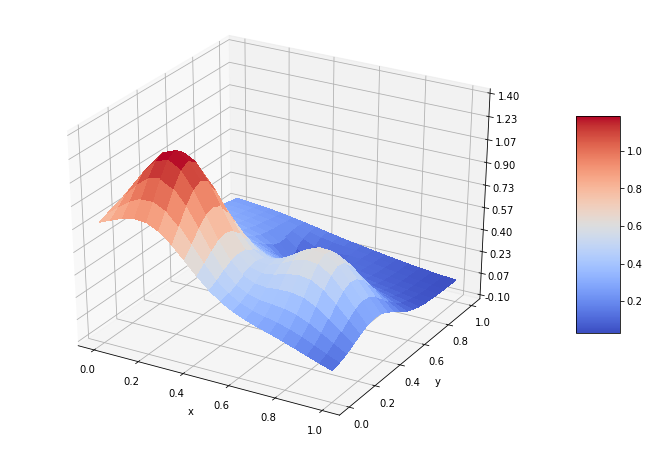

In [41]:
# Make data
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
x, y = np.meshgrid(x, y)

z = franke(x, y)

# Plot the surface
fig = plt.figure(figsize = (12, 8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the axes
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.xlabel("x")
plt.ylabel("y")

# Add a color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## Setup of data

In [42]:
@jit
def designMatrix(x, y, order):
    n = x.size
    p = int((order + 1) * (order + 2) / 2) # number of columns in X. (from sum of numbers up to order + 1 formula). 21 for order = 5
    X = np.zeros((n, p))
    feature = 0
    for x_power in range(order + 1):
        for z_power in range(order - x_power + 1):
            X[:, feature] = x**x_power * y**z_power
            feature += 1
    return X

In [43]:
def scale(X_train, X_test):
    scaler = StandardScaler() #subtracts mean from each feature and divides by the standard deviation
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_train[:, 0] = 1 # scaling removed the intercept terms
    X_test = scaler.transform(X_test)
    X_test[:, 0] = 1
    return X_train, X_test

In [81]:
def data(n, order):
    x = np.random.rand(n) #an array of 100 unordered uniform random numbers from 0 to 1
    y = np.random.rand(n)
    noise = np.random.randn(n) / 10
    
    z = franke(x, y) + noise
    X = designMatrix(x, y, order)
    
    return X, z

## Regression methods

In [78]:
def OLS(X, y, lmda=None, p=None):
    beta = np.linalg.inv(X.T @ X) @ X.T @ y # beta = (X.T X)^-1 X.T y
    return beta

def ridge(X, y, lmda, p):
    beta = np.linalg.inv(X.T @ X + lmda * np.eye(p)) @ X.T @ y
    return beta

#beta = np.linalg.pinv(X_train) @ z_train # finds OLS for singular matrix using SVD and psuedoinverse

## Part a): Ordinary Least Square (OLS) on the Franke function 

In [80]:
# Constants
n = 100 # datapoints
order = 5 # max order of polynomials
# Setup of data
X, z = data(n, order)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2)
X_train, X_test = scale(X_train, X_test)
# OLS regression
beta = ridge(X_train, z_train, 1, 21)
z_mdl = X_test @ beta
print(mean_squared_error(z_mdl, z_test))

0.023135182596395843


## Part b)

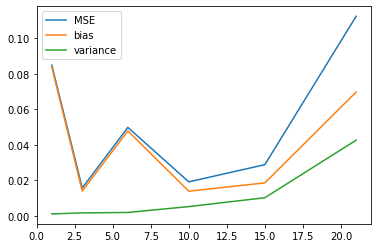

In [67]:
n_boostraps = 20
z_pred = np.empty((n_boostraps, z_test.size))
order = 5
p_arr = [(i + 1) * (i + 2) / 2 for i in range(order + 1)]
mse_arr = np.zeros(len(p_arr))
bias_arr = np.zeros(len(p_arr))
var_arr = np.zeros(len(p_arr))

for j in range(order+1):
    X = designMatrix(x, y, j)
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2)
    X_train, X_test = scale(X_train, X_test)
    for i in range(n_boostraps):
        X_, z_ = resample(X_train, z_train)
        z_pred[i] = X_test @ OLS(X_, z_)

    mse_arr[j] = np.mean( np.mean((z_test - z_pred)**2, axis=0, keepdims=True) )
    bias_arr[j] = np.mean( (z_test - np.mean(z_pred, axis=0, keepdims=True))**2 )
    var_arr[j] = np.mean( np.var(z_pred, axis=0, keepdims=True) )
    
plt.plot(p_arr, mse_arr, label='MSE')
plt.plot(p_arr, bias_arr, label='bias')
plt.plot(p_arr, var_arr, label='variance')
plt.legend()
plt.show()

## Part c)

Huske å begrunne hvorfor vi bruker/ikke bruker validation.

In [68]:
def split(data, k):
    n = len(data)
    fold_size = n // k #standard fold size, will be one larger if we need to get rid of extra elements
    test_start = 0
    extra = n % k #the first extra folds need one more element
    
    fold_indexes = []
    for i in range(k):
        if extra > 0:
            test_size = fold_size + 1
            extra -= 1
        else:
            test_size = fold_size
        training_size = n - test_size
        test_stop = test_start + test_size
        
        training_indexes = np.zeros(training_size, dtype=int)
        training_indexes[:test_start] = np.array(range(0, test_start)) #before testing
        training_indexes[test_start:] = np.array(range(test_stop, n)) #after testing
 
        testing_indexes = np.array(range(test_start, test_stop))

        fold_indexes.append([training_indexes, testing_indexes])
        test_start += test_size
        
    return fold_indexes

In [69]:
def CV_mse(x, y, z, order, k, reg_func):
    MSE = 0
    X = designMatrix(x, y, order)

    for train_inds, test_inds in split(X, k):
        X_train = X[train_inds]
        X_test = X[test_inds]
        X_train, X_test = scale(X_train, X_test)

        z_train = z[train_inds]
        z_test = z[test_inds]

        beta = reg_func(X_train, z_train, 1, p)
        z_mdl = X_test @ beta
        MSE += mean_squared_error(z_mdl, z_test) / k
    return MSE

In [70]:
max_order = 8
p_arr = [(i + 1) * (i + 2) / 2 for i in range(order + 1)]
mse_arr = np.zeros(len(p_arr))
k = 10

for j in range(max_order + 1):
    mse_arr[j] = CV_mse(x, y, z, j, k, ridge)

plt.plot(p_arr, mse_arr)
plt.show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 100)

## Part f)

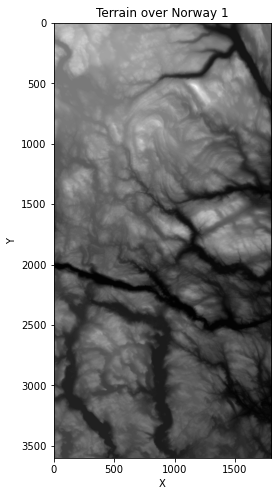

In [30]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Load the terrain
terrain = imread('SRTM_data_Norway_1.tif')
# Show the terrain
plt.figure(figsize=(4,8))
plt.title('Terrain over Norway 1')
plt.imshow(terrain, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [31]:
terrain = np.array(terrain)

In [32]:
terrain.shape

(3601, 1801)

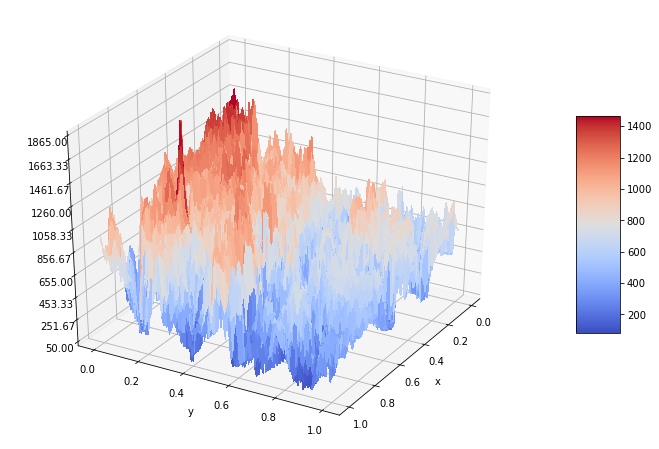

In [33]:
# Make data
x = np.linspace(0,1, np.shape(terrain)[1])
y = np.linspace(0,1, np.shape(terrain)[0])
x, y = np.meshgrid(x, y)

# Plot the surface
fig = plt.figure(figsize = (12, 8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, terrain, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the axes
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.xlabel("x")
plt.ylabel("y")

# Add a color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 30)
plt.show()

In [16]:
a = np.array([1,2,3,4,5,6,7,8])
b = np.array([0,4])
print(a[b])

[1 5]
